# Direct Regression from Images to Travel Behavior Variables

In [1]:
from setup import out_dir, data_dir, image_dir, model_dir
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import json
from collections import OrderedDict
import logging
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt
import glob
import pandas as pd
import time 

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms
import torch.nn.functional as F

try:
    from tensorboardX import SummaryWriter
    is_tensorboard_available = True
except Exception:
    is_tensorboard_available = False

from dataloader import get_loader, image_loader
from util_train_test import load_model, train, test

torch.backends.cudnn.benchmark = True

logging.basicConfig(
    format='[%(asctime)s %(name)s %(levelname)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)
logger = logging.getLogger(__name__)

global_step = 0

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
# demo_df = pd.read_csv(data_dir+"census_demo_df.csv")
# demo_df['census_tract'] = '17_'+demo_df['COUNTYA'].astype(str)+'_'+demo_df['TRACTA'].astype(str)

# demo_np = demo_df[['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
#          'pctwhite_alone','pct_nonwhite','pctblack_alone',
#          'pct_col_grad','pctPTcommute','avg_tt_to_work','inc_per_capita']].to_numpy()
# demo_np = demo_np / demo_np.max(axis=0)
# demo_cs = demo_df['census_tract'].tolist()


trp_bhv = pd.read_csv(data_dir+"origin_trip_behavior.csv")
trp_bhv['census_tract'] = [s1+"_"+s2+"_"+s3 for (s1, s2, s3) in zip(trp_bhv['state_fips_1'].astype(str), trp_bhv['county_fips_1'].astype(str), trp_bhv['tract_fips_1'].astype(str))]
trp_bhv['mode_share'] = trp_bhv['wtperfin_mode'] / trp_bhv['wtperfin_all']

trp_bhv = trp_bhv.sort_values(by='census_tract')
trp_gen = trp_bhv.groupby(by=['census_tract'], as_index=False).first()['wtperfin_all'].to_numpy()
trp_auto = trp_bhv[trp_bhv['mode']==2]['mode_share'].to_numpy()
trp_cs = trp_bhv['census_tract'].drop_duplicates().tolist()

[2021/09/24 00:54:18 numexpr.utils INFO] - Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2021/09/24 00:54:18 numexpr.utils INFO] - NumExpr defaulting to 8 threads.


In [3]:
zoomlevel = 'zoom13'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [4]:
args = {'image_size': 224, 
        'depth': -1,
       'base_channels':64,
       'output_dim':1,
       'cardinality':1,
       'epochs':200,
       'batch_size':16,
       'base_lr':0.001,
       'weight_decay':0.05,
       'momentum': 0.9,
       'nesterov': True,
       'milestones': '[150,225]',
       'lr_decay':0.1,
       'seed': 1234,
       'outdir':out_dir,
       'num_workers':8,
       'tensorboard':False,
       'save':True}

model_config = OrderedDict([
    ('arch', 'resnext'),
    ('depth', args['depth']),
    ('base_channels', args['base_channels']),
    ('cardinality', args['cardinality']),
    ('input_shape', (1, 3, 32, 32)),
    ('output_dim', args['output_dim'])
])

optim_config = OrderedDict([
    ('epochs', args['epochs']),
    ('batch_size', args['batch_size']),
    ('base_lr', args['base_lr']),
    ('weight_decay', args['weight_decay']),
    ('momentum', args['momentum']),
    ('nesterov', args['nesterov']),
    ('milestones', json.loads(args['milestones'])),
    ('lr_decay', args['lr_decay']),
])

data_config = OrderedDict([
    ('dataset', 'CIFAR10'),
    ('image_size', args['image_size'])
])

run_config = OrderedDict([
    ('seed', args['seed']),
    ('outdir', args['outdir']),
    ('save', args['save']),
    ('num_workers', args['num_workers']),
    ('tensorboard', args['tensorboard']),
])

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('data_config', data_config),
    ('run_config', run_config),
])

In [5]:
# parse command line arguments
#config = parse_args()
#logger.info(json.dumps(config, indent=2))

model_name = datetime.now().strftime("%m%d-%H%M")

run_config = config['run_config']
optim_config = config['optim_config']

# TensorBoard SummaryWriter
writer = SummaryWriter(model_name) if run_config['tensorboard'] else None

# set random seed
seed = run_config['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# create output directory
outdir = run_config['outdir']
if not os.path.exists(outdir):
    os.makedirs(outdir)

# save config as json file in output directory
outpath = os.path.join(outdir, 'config.json')
with open(outpath, 'w') as fout:
    json.dump(config, fout, indent=2)

In [6]:
# data loaders
# train_loader, test_loader = get_loader(optim_config['batch_size'], run_config['num_workers'])
train_loader, test_loader = image_loader(image_dir+zoomlevel+"/", data_dir, optim_config['batch_size'], run_config['num_workers'], 
                                         data_config['image_size'], recalculate_normalize=False)

In [7]:
criterion = nn.MSELoss(reduction='mean')
# criterion = my_loss

In [8]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num):
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count
        

In [22]:
# model
config['model_config']['input_shape'] = (1,3,data_config['image_size'],data_config['image_size'])

encoder = load_model(config['model_config']['arch'], 'Encoder', config['model_config'])
encoder = encoder.to(device)

Encoder torch.Size([1, 2048, 1, 1])


In [23]:
config['encoder'] = encoder
model = load_model('direct_regression','DirectRegression', config)
model = model.to(device)


In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=optim_config['base_lr'],
                             weight_decay=optim_config['weight_decay'])


In [25]:
ref1 = 0
ref2 = 0

for epoch in range(optim_config['epochs']):
        
    if logger is not None:
        logger.info('\nTrain {}'.format(epoch))

    model.train()

    loss_meter = AverageMeter()
    accuracy_meter = AverageMeter()
    start = time.time()
    
    return_trp_train = []
    train_true = []

    for step, (image_list, data) in enumerate(train_loader):
        
        if run_config['tensorboard'] and step == 0:
            image = torchvision.utils.make_grid(
                data, normalize=True, scale_each=True)
            writer.add_image('Train/Image', image, epoch)

        census_index = [trp_cs.index(i[i.rfind('/')+1:i.rfind('_')]) for i in image_list]
        census_data = trp_gen[census_index]/1000
#         census_data = trp_auto[census_index]
        train_true += census_data.tolist()

        census_data = torch.tensor(census_data).float().to(device)
        data = data.to(device)
        
        optimizer.zero_grad()

        out = model(data)
        return_trp_train += out.detach().cpu().numpy().tolist()

        loss = criterion(out.flatten(), census_data.flatten()).float()
        loss.backward()

        optimizer.step()

        num = data.size(0)

        loss_ = loss.item()
        loss_meter.update(loss_, num)

#         _, preds = torch.max(outputs, dim=1)
#         correct_ = preds.eq(targets).sum().item()
#         accuracy = correct_ / num
#         accuracy_meter.update(accuracy, num)

        if run_config['tensorboard']:
            writer.add_scalar('Train/RunningLoss', loss_, epoch)
#             writer.add_scalar('Train/RunningAccuracy', accuracy, epoch)
    return_trp_train = np.array(return_trp_train).flatten()
    train_true = np.array(train_true).flatten()
    
    r2 = r2_score(train_true, return_trp_train)
#     print(sorted(return_trp_train-train_true)[:10])
#     print(sorted(return_trp_train-train_true)[-10:])    
    
#     logger.info('Epoch {} Step {}/{} '
#                 'Loss {:.4f} ({:.4f}) '
#                 'Accuracy {:.4f} ({:.4f})'.format(
#                     epoch,
#                     step,
#                     len(train_loader),
#                     loss_meter.val,
#                     loss_meter.avg,
#                     accuracy_meter.val,
#                     accuracy_meter.avg,
#                 ))
  
    if logger is not None:
        logger.info('Epoch {} Step {}/{} '
                'Train Loss {:.8f} '.format(
                    epoch,
                    step,
                    len(train_loader),
                    loss_meter.avg
                ))
        logger.info('Train R2 {:.2f}'.format(r2))

    if run_config['tensorboard']:
        elapsed = time.time() - start
        writer.add_scalar('Train/Loss', loss_meter.avg, epoch)
        writer.add_scalar('Train/Accuracy', accuracy_meter.avg, epoch)
        writer.add_scalar('Train/Time', elapsed, epoch)
    
    model.eval()
        
    return_trp = []
    test_true = []
    
    loss_meter = AverageMeter()
    correct_meter = AverageMeter()
    start = time.time()
    for step, (image_list, data) in enumerate(test_loader):
#         if run_config['tensorboard'] and epoch == 0 and step == 0:
#             image = torchvision.utils.make_grid(
#                 data, normalize=True, scale_each=True)
#             writer.add_image('Test/Image', image, epoch)

        data = data.to(device)
        census_index = [trp_cs.index(i[i.rfind('/')+1:i.rfind('_')]) for i in image_list]
        census_data = trp_gen[census_index]/1000
#         census_data = trp_auto[census_index]
        
        test_true += census_data.tolist()
        
        census_data = torch.tensor(census_data).to(device)

        with torch.no_grad():            
            out = model(data)
        
        loss = criterion(out.flatten(), census_data.flatten())
       
        loss_ = loss.item()
#         print(loss_)
        num = data.size(0)
        loss_meter.update(loss_, num)
#         print(loss_meter.avg)

        return_trp += out.detach().cpu().numpy().tolist()

    return_trp = np.array(return_trp)
    test_true = np.array(test_true)
    r2 = r2_score(test_true, return_trp)

    
#     logger.info('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
#         epoch, loss_meter.avg, accuracy))

    if logger is not None:
        logger.info('Epoch {} Test Loss {:.8f}'.format(epoch, loss_meter.avg))
    
        elapsed = time.time() - start
#         logger.info('Elapsed {:.2f}'.format(elapsed))
        logger.info('Test R2 {:.2f}'.format(r2))

    else:
        print('Epoch {} Test Loss {:.8f}'.format(epoch, loss_meter.avg))
               
    if epoch % 5 == 0:
        if epoch > 50:
            if (np.abs(loss_ - ref1)/ref1<0.005) & (np.abs(loss_ - ref2)/ref2<0.005):
                print("Early stopping at epoch", epoch)
                break
            if (ref1 < loss_) & (ref1 < ref2):
                print("Diverging. stop.")
                break
            if loss_ < best:
                best = loss_
                best_epoch = epoch
        else:
            best = loss_
            best_epoch = epoch

        ref2 = ref1
        ref1 = loss_
        

[2021/09/24 01:52:17 __main__ INFO] - 
Train 0
[2021/09/24 01:52:57 __main__ INFO] - Epoch 0 Step 519/520 Train Loss 447.83531525 
[2021/09/24 01:52:57 __main__ INFO] - Train R2 0.01
[2021/09/24 01:52:58 __main__ INFO] - Epoch 0 Test Loss 331.22628240
[2021/09/24 01:52:58 __main__ INFO] - Test R2 -0.05
[2021/09/24 01:52:58 __main__ INFO] - 
Train 1
[2021/09/24 01:53:39 __main__ INFO] - Epoch 1 Step 519/520 Train Loss 430.95145041 
[2021/09/24 01:53:39 __main__ INFO] - Train R2 0.05
[2021/09/24 01:53:41 __main__ INFO] - Epoch 1 Test Loss 317.03733688
[2021/09/24 01:53:41 __main__ INFO] - Test R2 -0.00
[2021/09/24 01:53:41 __main__ INFO] - 
Train 2
[2021/09/24 01:54:21 __main__ INFO] - Epoch 2 Step 519/520 Train Loss 412.74436688 
[2021/09/24 01:54:21 __main__ INFO] - Train R2 0.09
[2021/09/24 01:54:23 __main__ INFO] - Epoch 2 Test Loss 322.72193855
[2021/09/24 01:54:23 __main__ INFO] - Test R2 -0.02
[2021/09/24 01:54:23 __main__ INFO] - 
Train 3
[2021/09/24 01:55:03 __main__ INFO] - Epo

[2021/09/24 02:11:08 __main__ INFO] - Test R2 -7.73
[2021/09/24 02:11:08 __main__ INFO] - 
Train 27
[2021/09/24 02:11:48 __main__ INFO] - Epoch 27 Step 519/520 Train Loss 286.87194072 
[2021/09/24 02:11:48 __main__ INFO] - Train R2 0.36
[2021/09/24 02:11:50 __main__ INFO] - Epoch 27 Test Loss 4283.31327908
[2021/09/24 02:11:50 __main__ INFO] - Test R2 -12.52
[2021/09/24 02:11:50 __main__ INFO] - 
Train 28
[2021/09/24 02:12:30 __main__ INFO] - Epoch 28 Step 519/520 Train Loss 305.62799616 
[2021/09/24 02:12:30 __main__ INFO] - Train R2 0.32
[2021/09/24 02:12:32 __main__ INFO] - Epoch 28 Test Loss 2002.48251039
[2021/09/24 02:12:32 __main__ INFO] - Test R2 -5.32
[2021/09/24 02:12:32 __main__ INFO] - 
Train 29
[2021/09/24 02:13:11 __main__ INFO] - Epoch 29 Step 519/520 Train Loss 293.00374327 
[2021/09/24 02:13:11 __main__ INFO] - Train R2 0.35
[2021/09/24 02:13:13 __main__ INFO] - Epoch 29 Test Loss 417.42646114
[2021/09/24 02:13:13 __main__ INFO] - Test R2 -0.32
[2021/09/24 02:13:13 __m

[2021/09/24 02:29:57 __main__ INFO] - Epoch 53 Test Loss 669.70507392
[2021/09/24 02:29:57 __main__ INFO] - Test R2 -1.11
[2021/09/24 02:29:57 __main__ INFO] - 
Train 54
[2021/09/24 02:30:37 __main__ INFO] - Epoch 54 Step 519/520 Train Loss 190.93885667 
[2021/09/24 02:30:37 __main__ INFO] - Train R2 0.58
[2021/09/24 02:30:39 __main__ INFO] - Epoch 54 Test Loss 1880.46720783
[2021/09/24 02:30:39 __main__ INFO] - Test R2 -4.93
[2021/09/24 02:30:39 __main__ INFO] - 
Train 55
[2021/09/24 02:31:19 __main__ INFO] - Epoch 55 Step 519/520 Train Loss 202.38040830 
[2021/09/24 02:31:19 __main__ INFO] - Train R2 0.55
[2021/09/24 02:31:21 __main__ INFO] - Epoch 55 Test Loss 1205.23745177
[2021/09/24 02:31:21 __main__ INFO] - Test R2 -2.80
[2021/09/24 02:31:21 __main__ INFO] - 
Train 56
[2021/09/24 02:32:01 __main__ INFO] - Epoch 56 Step 519/520 Train Loss 184.21646913 
[2021/09/24 02:32:01 __main__ INFO] - Train R2 0.59
[2021/09/24 02:32:03 __main__ INFO] - Epoch 56 Test Loss 588.72070741
[2021/0

Diverging. stop.


In [21]:
return_trp = np.array(return_trp).flatten()
train_true = np.array(train_true).flatten()

r2 = r2_score(return_trp, train_true)
print(sorted(return_trp-train_true)[:10])
print(sorted(return_trp-train_true)[-10:])    


[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


(array([320., 390., 130.,  50.,  20.,   0.,   0.,   0.,   0.,  20.]),
 array([  2.8499293 ,  14.49338237,  26.13683544,  37.78028851,
         49.42374158,  61.06719465,  72.71064772,  84.35410079,
         95.99755386, 107.64100693, 119.28446   ]),
 <a list of 10 Patch objects>)

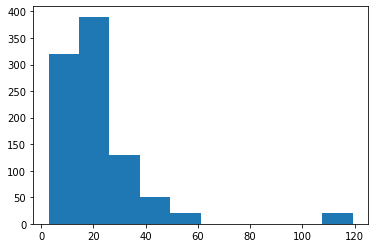

In [36]:
plt.hist(test_true)

(array([  4.,   5.,   9.,  44., 745.,  88.,  26.,   7.,   0.,   2.]),
 array([-320.92547607, -309.31758728, -297.70969849, -286.10180969,
        -274.4939209 , -262.8860321 , -251.27814331, -239.67025452,
        -228.06236572, -216.45447693, -204.84658813]),
 <a list of 10 Patch objects>)

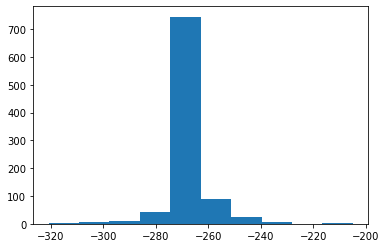

In [38]:
plt.hist(return_trp)

(array([3.840e+02, 1.419e+03, 1.490e+02, 4.000e+01, 1.400e+01, 2.000e+00,
        3.000e+00, 2.000e+00, 1.000e+00, 2.000e+00]),
 array([  0.3655386 ,  15.07823095,  29.79092331,  44.50361567,
         59.21630802,  73.92900038,  88.64169273, 103.35438509,
        118.06707745, 132.7797698 , 147.49246216]),
 <a list of 10 Patch objects>)

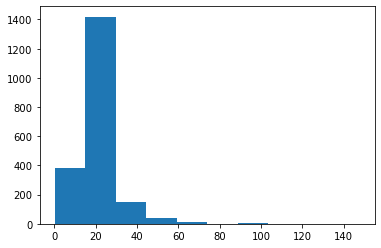

In [44]:
plt.hist(np.array(return_trp_train).flatten())

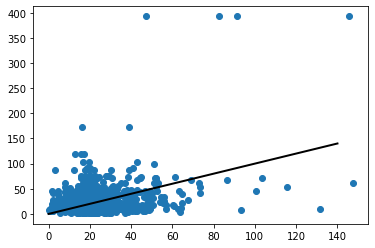

In [53]:
fig, ax = plt.subplots()
ax.scatter(np.array(return_trp_train).flatten(), train_true)
ax.plot([0,140],[0,140],linewidth=2, color='k')

(array([1810.,  183.,   14.,    3.,    2.,    0.,    0.,    0.,    0.,
           4.]),
 array([  1.1912392 ,  40.36614035,  79.5410415 , 118.71594265,
        157.8908438 , 197.06574495, 236.2406461 , 275.41554725,
        314.5904484 , 353.76534955, 392.9402507 ]),
 <a list of 10 Patch objects>)

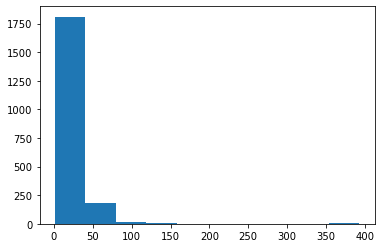

In [41]:
plt.hist(train_true)

In [24]:
return_trp

array([0.99951398, 0.99951398, 0.99951398, ..., 0.        , 0.        ,
       0.        ])

In [25]:
train_true

array([0.89380413, 0.61378575, 0.89122073, ..., 0.67766736, 0.9781502 ,
       0.72231509])

In [19]:
train_true

array([0.89380413, 0.61378575, 0.89122073, ..., 0.67766736, 0.9781502 ,
       0.72231509])

In [38]:
test_true

array([0.97134144, 0.97134144, 0.97134144, ..., 0.87365146, 0.87365146,
       0.87365146])

In [31]:
test_true.flatten().shape

(111,)

In [34]:
test_true[0].append([3,4,4])

In [35]:
test_true[0]

[0.9713414422826259,
 0.9713414422826259,
 0.9713414422826259,
 0.9713414422826259,
 0.9713414422826259,
 0.9713414422826259,
 0.9713414422826259,
 0.9713414422826259,
 0.9713414422826259,
 0.9713414422826259,
 0.9713414422826259,
 0.9713414422826259,
 0.9713414422826259,
 0.9713414422826259,
 0.9713414422826259,
 0.9713414422826259,
 [3, 4, 4]]

In [28]:
        if (config['run_config']['save']) & (best_epoch==epoch):
            torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
                model_dir+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+str(epoch)+".pt")

            files = glob.glob(model_dir+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_*.pt")

if config['run_config']['save']:
    for f in files:
        e = int(f.split("_")[-1].split(".")[0])
        if e != best_epoch:
            os.remove(f)
            
if run_config['tensorboard']:
    outpath = os.path.join(outdir, 'all_scalars.json')
    writer.export_scalars_to_json(outpath)

IndentationError: expected an indented block (<ipython-input-28-526413893998>, line 7)